# ResNet 구현
- 딥러닝에서 제일 유명한 모델 중 하나

In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [21]:
np.random.seed(7777)
tf.random.set_seed(7777)

### ResNet

![](../statics/imgs/resnet.png)

### ResNet의 핵심은 Skip Connection

![](../statics/imgs/skipconnection.png)

In [22]:
# output 값에 input 값을 더하는 것

### 2. Functional API 

`tf.keras.Sequential` 보다 더 유연하게 모델을 정의할 수 있는 방법

In [23]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add
                                                                              # 입력받은 것을 더해주는 레이어

In [24]:
# 함수로 구현!
def build_resnet(input_shape):
    inputs = Input(input_shape)

    net = Conv2D(32, kernel_size=3, strides= 2, padding='same', activation='relu')(inputs)
    net = MaxPool2D()(net)

    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)

    net1_1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net = Add()([net1_1, net3])

    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)

    net = Add()([net, net3])

    net = MaxPool2D()(net)

    net = Flatten()(net)
    net = Dense(10, activation='softmax')(net)

    model = tf.keras.Model(inputs=inputs, outputs = net)

    return model

In [25]:
model = build_resnet((32, 32, 3))   # color 이미지이기 때문에 3

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 32)   896         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 8, 8, 32)    0           ['conv2d_8[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 8, 8, 64)     2112        ['max_pooling2d_2[0][0]']        
                                                                                            

## CIfar10 dataset을 이용해 학습을 해본다

In [27]:
class DataLoader():

    def __init__(self):
        (self.train_x, self.train_y), \
            (self.test_x, self.test_y) = tf.keras.datasets.cifar10.load_data()

        # (train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

    def validate_pixel_scale(self, x):
        return 255 >= x.max() and 0 <= x.min()

    def scale(self, x):
        return (x / 255.0).astype(np.float32)

    def preprocess_dataset(self, dataset):
        feature, target = dataset

        validated_x = np.array([x for x in feature if self.validate_pixel_scale(x)])
        validated_y = np.array([y for x,y in zip(feature, target) if self.validate_pixel_scale(x)])

        # scale
        scaled_x = np.array([self.scale(x) for x in validated_x])
        
        # flatten   CNN에서는 안쓴다고 함
        # flatten_x = scaled_x.reshape((scaled_x.shape[0], -1))

        # expand
        # expanded_x = scaled_x[:, :, :, np.newaxis]      # 컬러 이미지는 expand가 필요가 없다.
                                        # 가짜 차원 하나를 추가한다.
                              # 인덱스 전체
                                # height
                                    # width


        # label encoding
        ohe_y = np.array([tf.keras.utils.to_categorical(y, num_classes=10) for y in validated_y])
                                    # shape 1을 없애야 한다. >> squeeze


        return scaled_x, np.squeeze(ohe_y, axis=1)  #ohe_y      
                # scaled_x 로 변경
                        # train_y, test_y의 shape 1을 제거하기 위해서
    
    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))
    
    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

In [28]:
loader = DataLoader()

train_x, train_y = loader.get_train_dataset()

test_x, test_y = loader.get_test_dataset()   # loader.get_test_dataset()

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)


In [29]:
# 학습하기
lr = 0.03       # 각자마다 좋아하는 러닝 레이트(초기값)가 있다. 
opt = tf.keras.optimizers.Adam(lr)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [30]:
hist = model.fit(train_x, train_y, epochs=1, batch_size=128, validation_data=(test_x, test_y))

391/391 [==============================] - 31s 78ms/step - loss: 2.4849 - accuracy: 0.1001 - val_loss: 2.3034 - val_accuracy: 0.1000


In [31]:
# epochs 10으로 해서 나타내보고, plot 그려보기

Epoch 1/10
391/391 [==============================] - 31s 80ms/step - loss: 2.3040 - accuracy: 0.0994 - val_loss: 2.3034 - val_accuracy: 0.1000
Epoch 2/10
391/391 [==============================] - 41s 104ms/step - loss: 2.3047 - accuracy: 0.0999 - val_loss: 2.3041 - val_accuracy: 0.1000
Epoch 3/10
391/391 [==============================] - 31s 80ms/step - loss: 2.3046 - accuracy: 0.0995 - val_loss: 2.3039 - val_accuracy: 0.1000
Epoch 4/10
391/391 [==============================] - 29s 73ms/step - loss: 2.3044 - accuracy: 0.0978 - val_loss: 2.3043 - val_accuracy: 0.1000
Epoch 5/10
391/391 [==============================] - 27s 69ms/step - loss: 2.3046 - accuracy: 0.1008 - val_loss: 2.3043 - val_accuracy: 0.1000
Epoch 6/10
391/391 [==============================] - 30s 77ms/step - loss: 2.3046 - accuracy: 0.0997 - val_loss: 2.3053 - val_accuracy: 0.1000
Epoch 7/10
391/391 [==============================] - 36s 91ms/step - loss: 2.3047 - accuracy: 0.0991 - val_loss: 2.3050 - val_accuracy

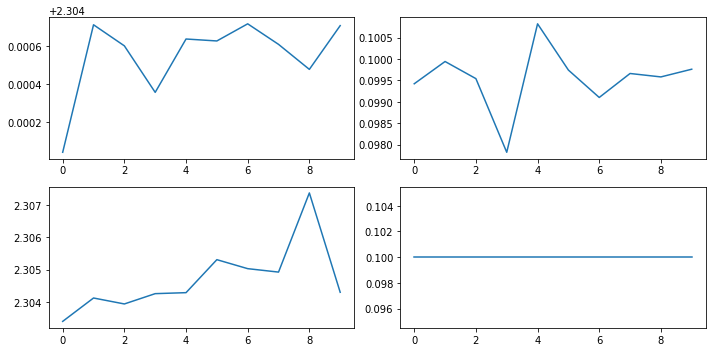

In [32]:
hist_2 = model.fit(train_x, train_y, epochs = 10, batch_size=128, validation_data=(test_x, test_y))

plt.figure(figsize=(10,5))
plt.subplot(221)    #2 * 2 * 1
plt.plot(hist_2.history['loss'])
plt.subplot(222)
plt.plot(hist_2.history['accuracy'])
plt.subplot(223)
plt.plot(hist_2.history['val_loss'])
plt.subplot(224)
plt.plot(hist_2.history['val_accuracy'])

plt.tight_layout()
plt.show()